# Load data

<https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29>

In [1]:
import sage
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [4]:
import numpy as np
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

In [5]:
model = CatBoostClassifier(iterations=50,
                           learning_rate=0.3,
                           depth=3)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

In [6]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


# Calculate importance (marginal distribution)

In [7]:
# Setup and calculate
imputer = sage.MarginalImputer(model, train[:512])
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test, Y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

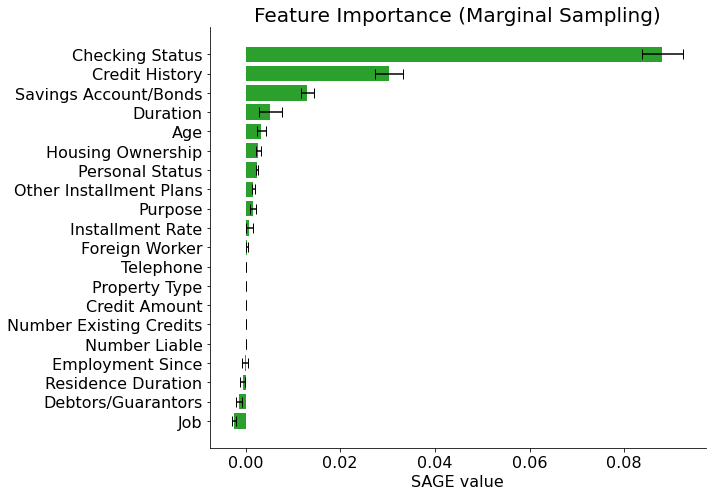

In [8]:
# Plot results
sage_values.plot(feature_names, title='Feature Importance (Marginal Sampling)')

# Train surrogate model

- Requires installing `removal-explanations` package into your Python environment (imported as `rexplain`)
- Install from here: https://github.com/iancovert/removal-explanations
- Note that in some cases (higher dimensional datasets), increasing the batch size can lead to much better results

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, BatchSampler
from rexplain.torch import MaskLayer1d
from copy import deepcopy
import matplotlib.pyplot as plt

In [10]:
# Setup
device = torch.device('cuda')
num_features = len(feature_names)

# Create surrogate model (outputs logits)
surrogate = nn.Sequential(
    MaskLayer1d(value=0),
    nn.Linear(2 * num_features, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 2)).to(device)

In [11]:
# For data normalization
mean = train.mean(axis=0)
std = train.std(axis=0)

# Prepare surrogate training data
X_surrogate = torch.tensor((train - mean) / std, dtype=torch.float32)
Y_surrogate = torch.tensor(model.predict_proba(train), dtype=torch.float32)

In [12]:
# Prepare validation dataset
X_val_surrogate = torch.tensor(
    ((val - mean) / std),
    dtype=torch.float32)
Y_val_surrogate = torch.tensor(
    model.predict_proba(val),
    dtype=torch.float32)

# Replicate rows
X_val_surrogate = X_val_surrogate.repeat(1000, 1)
Y_val_surrogate = Y_val_surrogate.repeat(1000, 1)

# Generate missingness
S_val = torch.ones(X_val_surrogate.shape)
for i in range(len(S_val)):
    num_included = np.random.choice(num_features + 1)
    S_val[i, num_included:] = 0
    S_val[i] = S_val[i, torch.randperm(num_features)]
    
# Create dataset iterator
val_set = TensorDataset(X_val_surrogate, Y_val_surrogate, S_val)
val_loader = DataLoader(val_set, batch_size=25000)

# Function to measure validation performance
def validate(model, loss_fn):
    with torch.no_grad():
        # Setup
        mean_loss = 0
        N = 0

        # Iterate over validation set
        for x, y, S in val_loader:
            x = x.to(device)
            y = y.to(device)
            S = S.to(device)
            pred = model((x, S))
            loss = loss_fn(pred, y)
            N += len(x)
            mean_loss += len(x) * (loss - mean_loss) / N

    return mean_loss

In [13]:
# Custom loss function for soft cross entropy
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        return - torch.mean(
            torch.sum(pred.log_softmax(dim=1) * target, dim=1))

In [14]:
# Training parameters
lr = 1e-3
nepochs = 1000
early_stop_epochs = 10

# Set up for data loader
train_set = TensorDataset(X_surrogate, Y_surrogate)

# Loss function
loss_fn = SoftCrossEntropyLoss()
loss_list = []

for mbsize in (32, 512):
    # Optimizer
    optimizer = optim.Adam(surrogate.parameters(), lr=lr)

    # Data loader
    random_sampler = RandomSampler(
        train_set, replacement=True,
        num_samples=int(np.ceil(len(X_surrogate) / mbsize))*mbsize)
    batch_sampler = BatchSampler(random_sampler, batch_size=mbsize, drop_last=True)
    train_loader = DataLoader(train_set, batch_sampler=batch_sampler)

    # For saving best model
    min_epoch = 0
    best_model = deepcopy(surrogate)
    best_epoch_loss = validate(surrogate, loss_fn).item()
    best_epoch = 0

    # Begin training
    for epoch in range(nepochs):
        for i, (x, y) in enumerate(train_loader):
            # Prepare data
            x = x.to(device)
            y = y.to(device)

            # Generate subset
            S = torch.ones(mbsize, num_features, dtype=torch.float32, device=device)
            num_included = np.random.choice(num_features + 1, size=mbsize)
            for j in range(mbsize):
                S[j, num_included[j]:] = 0
                S[j] = S[j, torch.randperm(num_features)]

            # Make predictions
            pred = surrogate((x, S))
            loss = loss_fn(pred, y)

            # Optimizer step
            loss.backward()
            optimizer.step()
            surrogate.zero_grad()

        # End of epoch progress message
        val_loss = validate(surrogate, loss_fn).item()
        loss_list.append(val_loss)
        print('----- Epoch = {} -----'.format(epoch + 1))
        print('Val loss = {:.4f}'.format(val_loss))
        print('')

        # Check if best model
        if epoch >= min_epoch:
            if val_loss < best_epoch_loss:
                best_epoch_loss = val_loss
                best_model = deepcopy(surrogate)
                best_epoch = epoch
                print('New best epoch, val loss = {:.4f}'.format(val_loss))
                print('')
            else:
                # Check for early stopping
                if epoch - best_epoch == early_stop_epochs:
                    print('Stopping early')
                    break

    surrogate = best_model

----- Epoch = 1 -----
Val loss = 0.5923

New best epoch, val loss = 0.5923

----- Epoch = 2 -----
Val loss = 0.5891

New best epoch, val loss = 0.5891

----- Epoch = 3 -----
Val loss = 0.5882

New best epoch, val loss = 0.5882

----- Epoch = 4 -----
Val loss = 0.5888

----- Epoch = 5 -----
Val loss = 0.5889

----- Epoch = 6 -----
Val loss = 0.5885

----- Epoch = 7 -----
Val loss = 0.5888

----- Epoch = 8 -----
Val loss = 0.5893

----- Epoch = 9 -----
Val loss = 0.5882

----- Epoch = 10 -----
Val loss = 0.5877

New best epoch, val loss = 0.5877

----- Epoch = 11 -----
Val loss = 0.5890

----- Epoch = 12 -----
Val loss = 0.5888

----- Epoch = 13 -----
Val loss = 0.5878

----- Epoch = 14 -----
Val loss = 0.5876

New best epoch, val loss = 0.5876

----- Epoch = 15 -----
Val loss = 0.5866

New best epoch, val loss = 0.5866

----- Epoch = 16 -----
Val loss = 0.5879

----- Epoch = 17 -----
Val loss = 0.5877

----- Epoch = 18 -----
Val loss = 0.5880

----- Epoch = 19 -----
Val loss = 0.5874

-

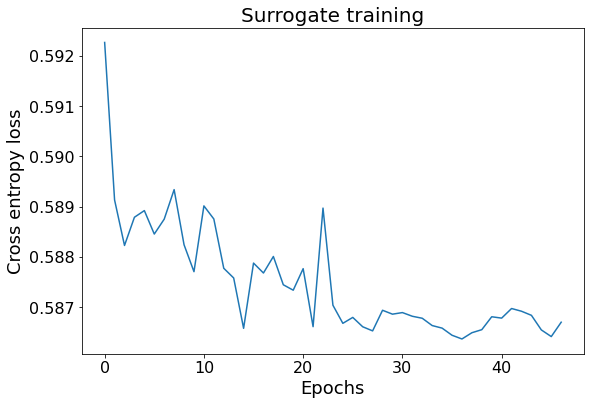

In [15]:
# Plot loss during training
plt.figure(figsize=(9, 6))
plt.plot(loss_list)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Cross entropy loss', fontsize=18)
plt.tick_params(labelsize=16)
plt.title('Surrogate training', fontsize=20)
plt.show()

# Calculate importance (surrogate)

- MUCH faster than with sampling from marginal distribution

In [16]:
# Set up imputer object
class Imputer:
    def __init__(self):
        self.num_groups = num_features
    
    def __call__(self, x, S):
        # Call surrogate model (with data normalization)
        return surrogate(
            (torch.tensor((x - mean) / std, dtype=torch.float32, device=device),
             torch.tensor(S, dtype=torch.float32, device=device))
        ).softmax(dim=1).cpu().data.numpy()

imputer = Imputer()

# Calculate SAGE values
estimator = sage.PermutationEstimator(imputer, 'cross entropy')
sage_values = estimator(test, Y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

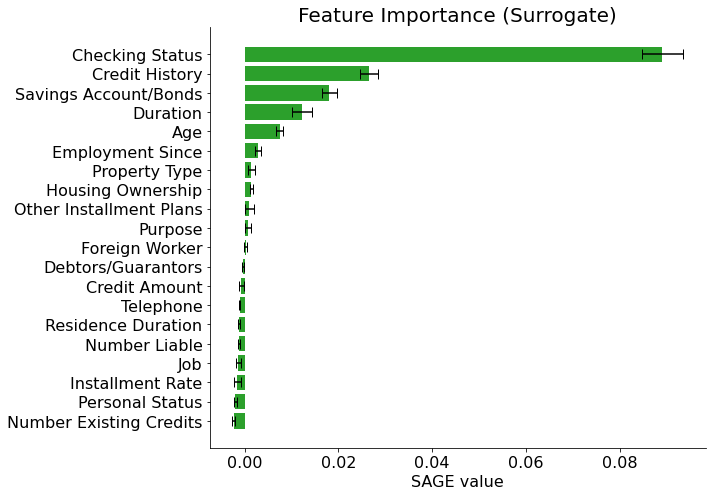

In [17]:
# Plot results
sage_values.plot(feature_names, title='Feature Importance (Surrogate)')